In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from functools import partial

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_recall_curve,
    RocCurveDisplay, 
    roc_curve,
    f1_score,
    precision_score, 
)

import optuna
import seaborn as sns

pd.options.display.max_colwidth = 200

RANDOM_STATE = 42

# Download CDC Diabetes Health Indicators dataset

In [2]:

# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
df = cdc_diabetes_health_indicators.data.features 
target = cdc_diabetes_health_indicators.data.targets.Diabetes_binary

Dataset metadata

In [3]:
# metadata 
print(json.dumps(cdc_diabetes_health_indicators.metadata, indent=4))

{
    "uci_id": 891,
    "name": "CDC Diabetes Health Indicators",
    "repository_url": "https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators",
    "data_url": "https://archive.ics.uci.edu/static/public/891/data.csv",
    "abstract": "The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ",
    "area": "Health and Medicine",
    "tasks": [
        "Classification"
    ],
    "characteristics": [
        "Tabular",
        "Multivariate"
    ],
    "num_instances": 253680,
    "num_features": 21,
    "feature_types": [
        "Categorical",
        "Integer"
    ],
    "demographics": [
        "Sex",
        "Age",
        "Education Level",


Features information 

In [4]:
features = cdc_diabetes_health_indicators.variables
features[['name', 'role', 'type', 'description', 'missing_values']]

,name,role,type,description,missing_values
0,ID,ID,Integer,Patient ID,no
1,Diabetes_binary,Target,Binary,0 = no diabetes 1 = prediabetes or diabetes,no
2,HighBP,Feature,Binary,0 = no high BP 1 = high BP,no
3,HighChol,Feature,Binary,0 = no high cholesterol 1 = high cholesterol,no
4,CholCheck,Feature,Binary,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years,no
5,BMI,Feature,Integer,Body Mass Index,no
6,Smoker,Feature,Binary,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes,no
7,Stroke,Feature,Binary,(Ever told) you had a stroke. 0 = no 1 = yes,no
8,HeartDiseaseorAttack,Feature,Binary,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes,no
9,PhysActivity,Feature,Binary,physical activity in past 30 days - not including job 0 = no 1 = yes,no


In [5]:
binary_feature_names = list(features[(features.type == 'Binary') & (features.role != 'Target')].name)
binary_feature_names

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'DiffWalk',
 'Sex']

# EDA

## Missing values

From the dataset description we know that there are no missing values

## Target variable analysis

### Diabetes rate

In [6]:
target.value_counts(normalize=True)

Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64

We can see that the dataset is fairly imbalanced, but not extremely.  
We can go about without trying any imbalanced dataset treatment but we need to choose an appropriate metric to assess the quality of the model predictions.

In [7]:
# Create (train-val)-test split to analyse only features in the train-val part

df_full_train, df_test, y_full_train, y_test = train_test_split(df, target, test_size=0.2, random_state=RANDOM_STATE)

In [8]:
# Sanity check
len(df_full_train), len(y_full_train), len(df_test), len(y_test)

(202944, 202944, 50736, 50736)

##  Features analysis

### Features preview

In [56]:
df_full_train_w_target = df_full_train.copy()
df_full_train_w_target['target'] = y_full_train
len(df_full_train), len(df_full_train.drop_duplicates()), len(df_full_train_w_target), len(df_full_train_w_target.drop_duplicates())

(202944, 184489, 202944, 185585)

In [60]:
df_full_train = df_full_train_w_target.drop_duplicates().drop(columns=['target'])
y_full_train = df_full_train_w_target.drop_duplicates().target

In [89]:
len(df_full_train)

185585

In [61]:
df_full_train.head().T

,31141,98230,89662,208255,233415
HighBP,0,0,1,0,0
HighChol,1,0,1,1,1
CholCheck,1,1,1,1,1
BMI,20,34,24,27,24
Smoker,1,0,0,0,0
Stroke,0,0,0,0,0
HeartDiseaseorAttack,0,0,0,0,0
PhysActivity,1,1,1,1,1
Fruits,1,0,1,1,1
Veggies,1,1,1,1,1


All the features in the dataset are represented as numbers so let's quickly plot them all to get an initial idea

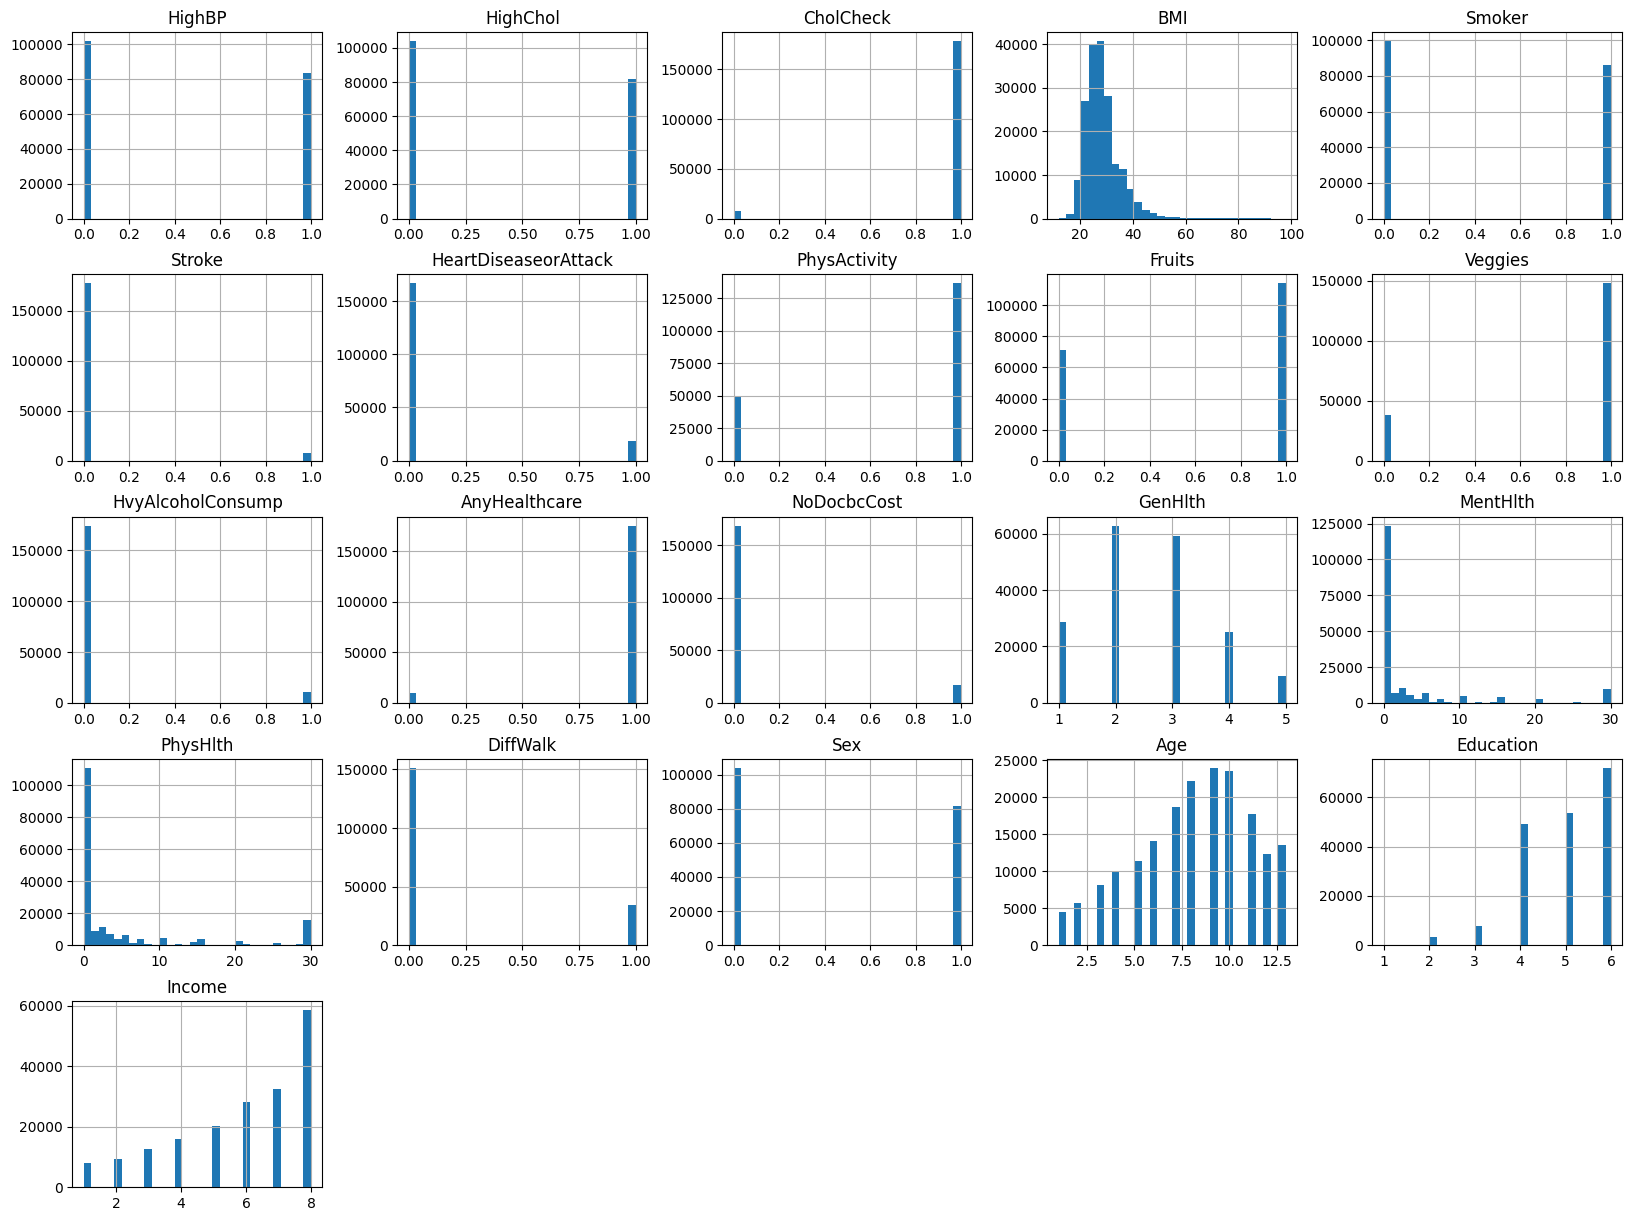

In [62]:
df_full_train.hist(figsize=(20, 15), bins=30);

We can conclude that all the variables except for BMI are categorical.  
With GenHlth, MentHlth, PhysHlth, Age, Education, and Income being ordinal. Since these features have a natural and meaningful order, we'll treat them as numbers.  
We see that there's no need to perform any one-hot encoding because the Binary features are already one-hot encoded and the other are represented as numbers.

The observed features suggest that Decision tree-based algorithms, like Random Forest, xgboost etc should work well for this case.

## Mutual information

Let's see how much we can learn about the target if we know the value of a feature

For this case it's valid to treat all the features as categorical since the number of unique values is low even for BMI and the majority of values falls between 20 and 40 

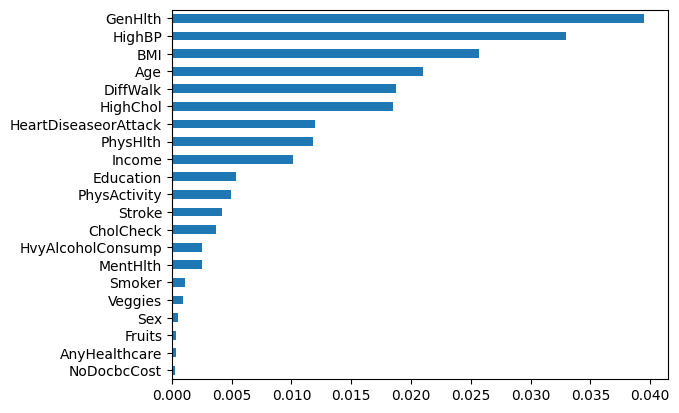

In [63]:
mutual_information = df_full_train.apply(partial(mutual_info_score, y_full_train))
fig = plt.figure()
mutual_information.sort_values().plot(kind="barh")
plt.yticks(
    range(len(mutual_information)), labels=mutual_information.sort_values().index
);

We see that the most important features on their own are Genaral Health, Blood Pressure, Age, and Walking Difficulty  
And at least according to this dataset eating Fruits and Vegetables doesn't seem to help with escaping Diabetes.

## Correlation

In [64]:
df_full_train.loc[: , ~df_full_train.columns.isin(binary_feature_names)].corrwith(y_full_train)

BMI          0.206784
GenHlth      0.277929
MentHlth     0.056353
PhysHlth     0.157492
Age          0.176532
Education   -0.104633
Income      -0.143127
dtype: float64

/var/folders/xp/nfq4xfg90wzfc3w1r68x1hkr0000gp/T/ipykernel_64492/855902750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical_features_with_target['target'] = y_full_train


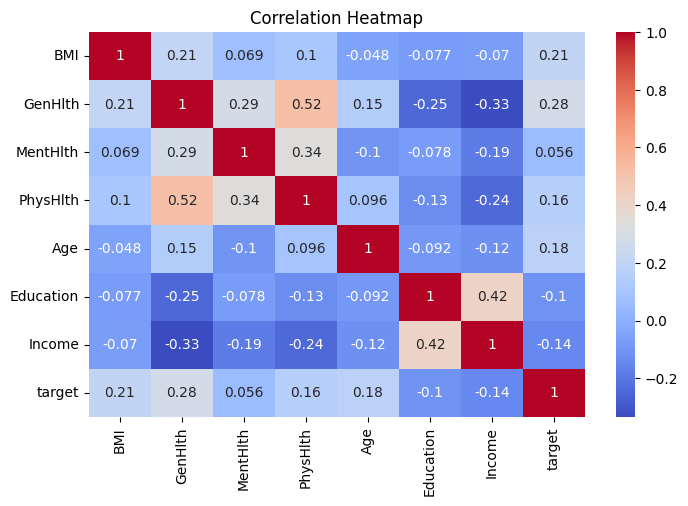

In [65]:
df_numerical_features_with_target = df_full_train.loc[: , ~df_full_train.columns.isin(binary_feature_names)]
df_numerical_features_with_target['target'] = y_full_train
plt.figure(figsize=(8, 5))
sns.heatmap(df_numerical_features_with_target.corr().round(3), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We don't see huge correlation of individual features with the target

As expected:  
Physical Health is moderately correlated with General Health  
Income is moderately correlated with Education


## Train-val split

In [66]:
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.2, random_state=RANDOM_STATE)

In [67]:
X_train = df_train
X_val = df_val
X_test = df_test

## Choice of metric

It makes sense to use **recall** as a main metric.  
In the context of diabetes diagnosis, optimizing for recall would mean minimizing false negatives, ensuring that as many actual cases of diabetes are correctly identified as possible.  

Optimizing for recall is important when missing a true positive (i.e., failing to diagnose a person with diabetes) has serious consequences, and you want to be comprehensive in capturing positive cases.

# Utility functions

print precision, recall, F1-score:

In [68]:
def precision_recall_f1(model, X=X_val, y=y_val):
    print(
        f"recall: {recall_score(y_true=y, y_pred=model.predict(X)):.3f}\n"
        f"precision: {precision_score(y_true=y, y_pred=model.predict(X)):.3f}\n"
        f"F-1 score: {f1_score(y_true=y, y_pred=model.predict(X)):.3f}\n"
    )

plot confusion matrix

In [69]:
def plot_confusion_matrix(
    model, y_true=y_val, X=X_val, normalize="true", dataset_name="validation", ax=None
):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y_true,
        normalize=normalize,
        display_labels=["No diabetes", "Diabetes"],
        ax=ax
    )

plot precision recall curve

In [70]:
def plot_precision_recall_curve(model, y_true=y_val, X=X_val):
    y_pred_probs = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()

plot ROC curve

In [71]:
def plot_roc_curve(model, y_true=y_val, X=X_val, dataset_name="validation", ax=None):
    RocCurveDisplay.from_estimator(model, X, y_true, ax=ax)
    plt.title(f"Receiver Operating Characteristic (ROC) Curve for {dataset_name} set")

In [72]:
def plot_cm_roc(model, y_true=y_val, X=X_val, dataset_name="validation"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plot_confusion_matrix(model=model, y_true=y_true, X=X, dataset_name=dataset_name, ax=ax1)
    plot_roc_curve(model=model, y_true=y_true, X=X, dataset_name=dataset_name, ax=ax2)

# Create scaled features

At least for the sake of convergence, features should be on the same scale for Logistic Regression

In [73]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_val_scaled = min_max_scaler.transform(X_val)

# Train Logistic Regression

Let's start with a baseline Logistic regression

In [74]:
base_model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
base_model.fit(X_train_scaled, y_train)
print('On training set:')
precision_recall_f1(base_model, X=X_train_scaled, y=y_train)
print('On validation set:')
precision_recall_f1(base_model , X=X_val_scaled)

On training set:
recall: 0.147
precision: 0.537
F-1 score: 0.230

On validation set:
recall: 0.147
precision: 0.546
F-1 score: 0.231



We can see that recall value is really poor. And all the metrics are very low even on training set.  
Most likely, Logistic Regression is not an adequate choice of algorithm in this case since there are too many binary features.  
Let's visualize all the metrics better to then compare the baseline with the best model

## Confusion matrix and ROC curve

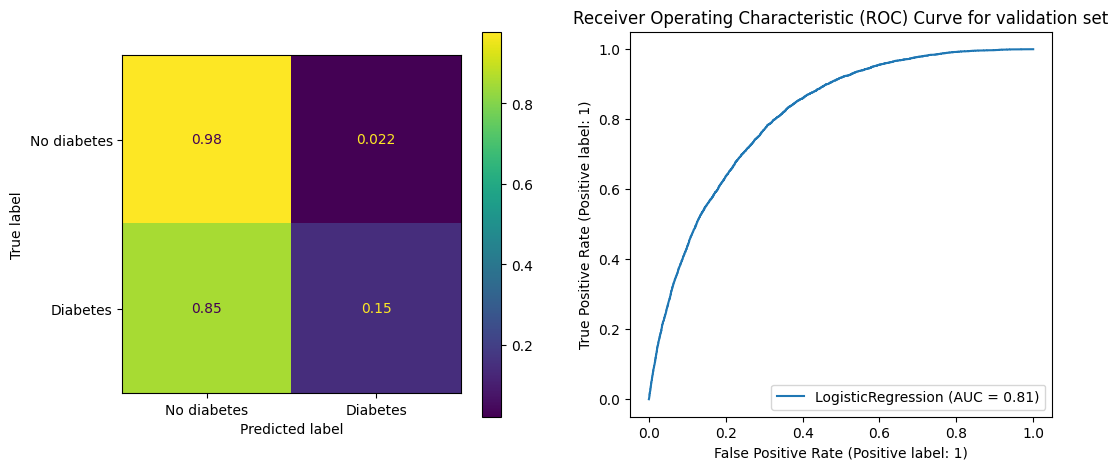

In [75]:
plot_cm_roc(model=base_model, X=X_val_scaled)

Confusion matrix suggests that the trained model is very close to naive model that just predicts everything as negative.  
That's why we see a fairly high precision score. But overall the quality of the model is unacceptable since it doesn't help us to detect Diabetes cases

## Precision recall curve

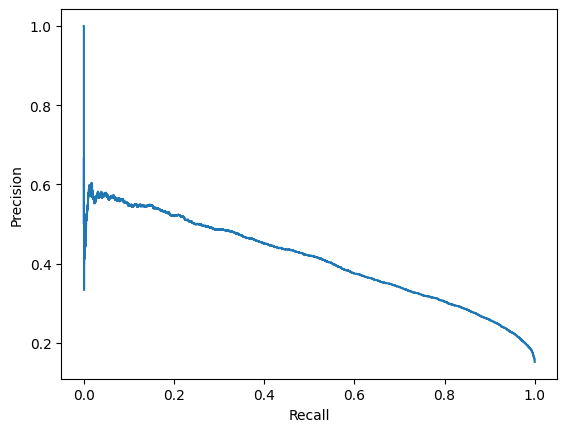

In [76]:
plot_precision_recall_curve(model=base_model, X=X_val_scaled)

# Train Decision Tree Classifier

In [77]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

print('Decision tree model: ')

print('On training set:')
precision_recall_f1(model=dt, X=X_train, y=y_train)
print('On validation set: ')
precision_recall_f1(model=dt)

print('Baseline model on training set:')
precision_recall_f1(model=base_model, X=X_train_scaled, y=y_train)

Decision tree model: 
On training set:
recall: 0.969
precision: 1.000
F-1 score: 0.984

On validation set: 
recall: 0.348
precision: 0.307
F-1 score: 0.327

Baseline model on training set:
recall: 0.147
precision: 0.537
F-1 score: 0.230



We can see several things:

1. Desicion tree definitely overfits on the training set 
2. Even overfitting Decision tree is still better than the baseline Logistic Regression model.

Potentially by optimizing hyperparameters we can achieve better results, but Desicion Tree is rather trivial, so I wouldn't expect much improvement.

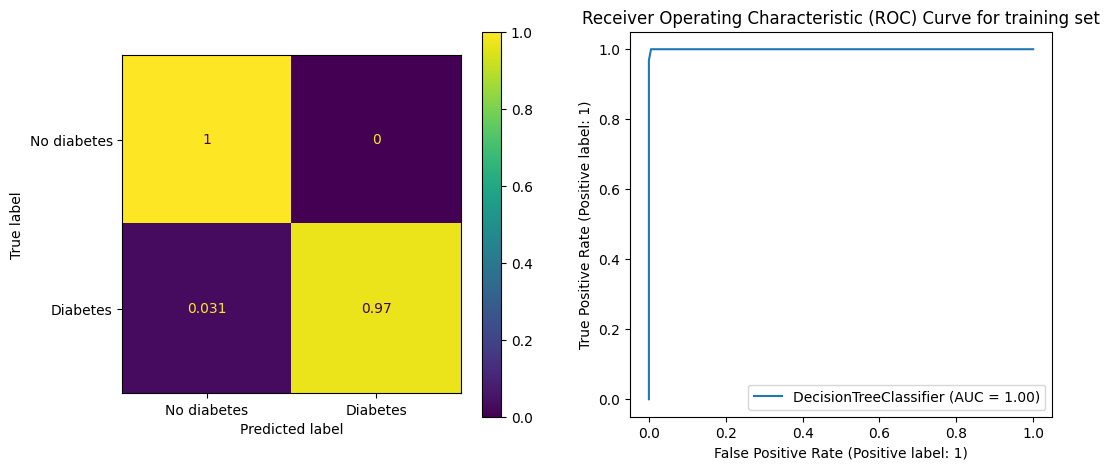

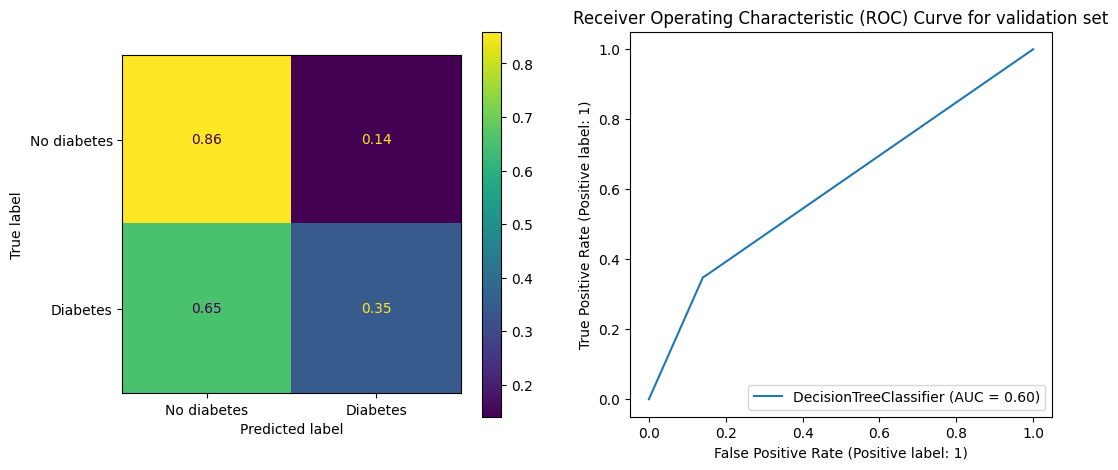

In [78]:
plot_cm_roc(model=dt, X=X_train,y_true=y_train, dataset_name='training')
plot_cm_roc(model=dt)

## Finetune Decision Tree parameters with optuna

We will try to fine-tune the parameters that in the majority of cases appear to be the most important:

1. `max_depth`
2. `min_samples_leaf`

In [79]:
# Create a function to optimize
def objective(trial):
    # Define search spaces for hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)

    # Create and fit the logistic regression model with the chosen hyperparameters
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = clf.predict(X_val)

    return recall_score(y_val, y_pred)

In [80]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Start the optimization process
study.optimize(objective, n_trials=500, n_jobs=-1)


[I 2023-11-04 21:13:59,529] A new study created in memory with name: no-name-84a6a40f-36aa-4478-a715-2c991f933144
[I 2023-11-04 21:13:59,833] Trial 5 finished with value: 0.11790780141843972 and parameters: {'max_depth': 6, 'min_samples_leaf': 35}. Best is trial 5 with value: 0.11790780141843972.
[I 2023-11-04 21:13:59,931] Trial 0 finished with value: 0.17677304964539006 and parameters: {'max_depth': 27, 'min_samples_leaf': 49}. Best is trial 0 with value: 0.17677304964539006.
[I 2023-11-04 21:13:59,960] Trial 3 finished with value: 0.18014184397163122 and parameters: {'max_depth': 14, 'min_samples_leaf': 24}. Best is trial 3 with value: 0.18014184397163122.
[I 2023-11-04 21:14:00,035] Trial 1 finished with value: 0.17677304964539006 and parameters: {'max_depth': 17, 'min_samples_leaf': 49}. Best is trial 3 with value: 0.18014184397163122.
[I 2023-11-04 21:14:00,075] Trial 10 finished with value: 0.09078014184397164 and parameters: {'max_depth': 5, 'min_samples_leaf': 16}. Best is tri

In [81]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

best_dt = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
best_dt.fit(X_train, y_train)

print('Decision tree best model: ')

print('On training set:')
precision_recall_f1(model=best_dt, X=X_train, y=y_train)
print('On validation set: ')
precision_recall_f1(model=best_dt)


print('Decision tree base model: ')
print('On validation set: ')
precision_recall_f1(model=dt)


Best Hyperparameters: {'max_depth': 40, 'min_samples_leaf': 1}
Decision tree best model: 
On training set:
recall: 0.969
precision: 1.000
F-1 score: 0.984

On validation set: 
recall: 0.348
precision: 0.307
F-1 score: 0.327

Decision tree base model: 
On validation set: 
recall: 0.348
precision: 0.307
F-1 score: 0.327



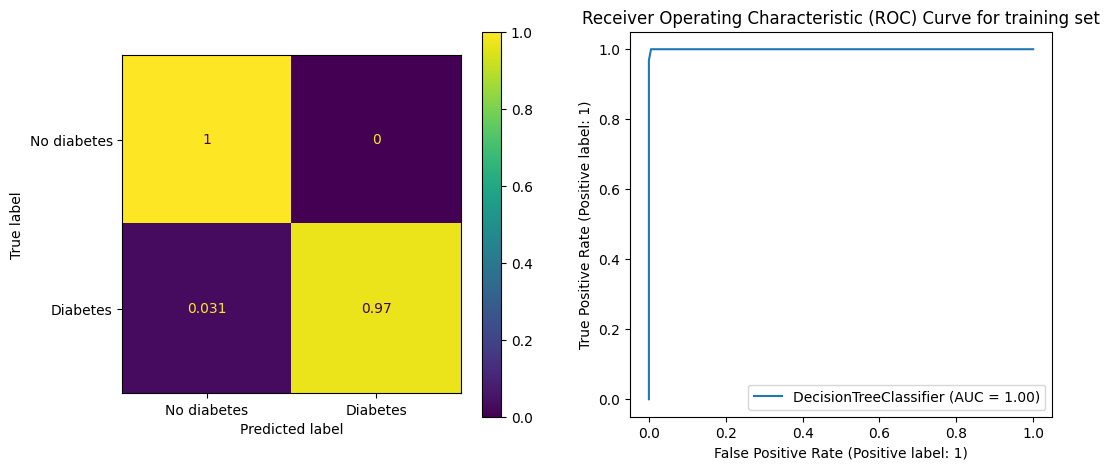

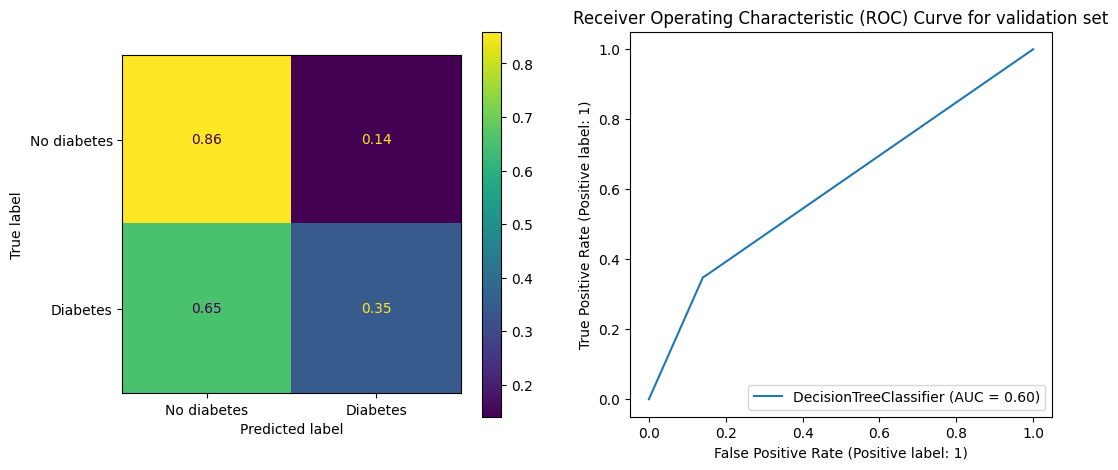

In [82]:
plot_cm_roc(model=best_dt, X=X_train,y_true=y_train, dataset_name='training')
plot_cm_roc(model=best_dt);

As expected, fine-tuning DecisionTreeClassifier parameters, haven't resulted in any significant improvement.  
By restricting the depth we slightly reduced overfitting, but as we can see, overfitting is still huge.  
At the same time lowered the recall score on the validation dataset

It's time to try ensembling using Random Forest

# Train Random Forest Classifier

In [83]:
from sklearn.ensemble import  RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

print('Random Forest base model: ')

print('On training set:')
precision_recall_f1(model=rf, X=X_train, y=y_train)
print('On validation set: ')
precision_recall_f1(model=rf)



Random Forest base model: 
On training set:
recall: 0.973
precision: 0.995
F-1 score: 0.984

On validation set: 
recall: 0.169
precision: 0.485
F-1 score: 0.250



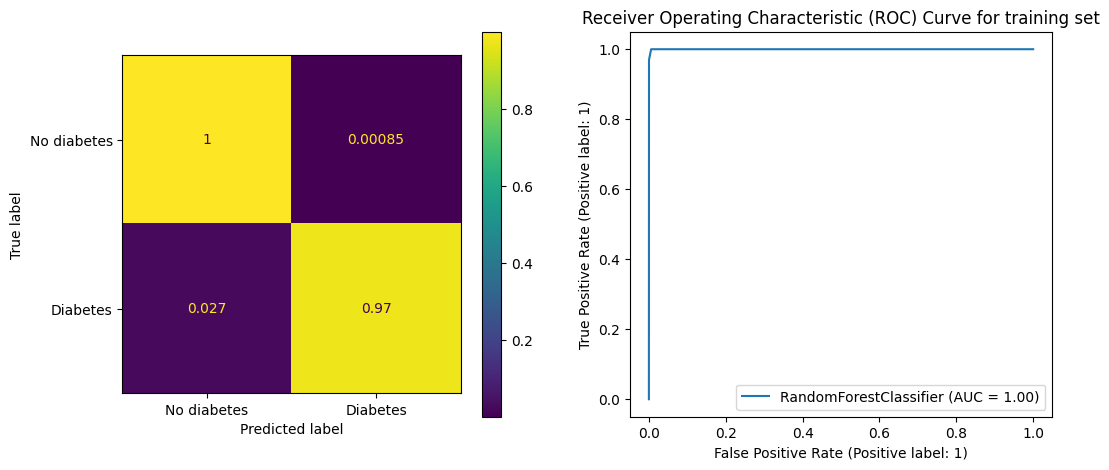

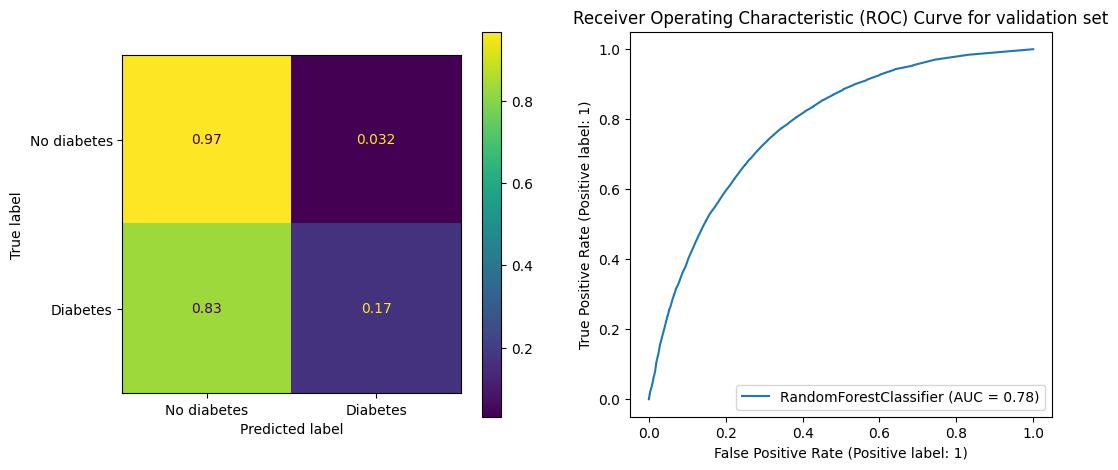

In [84]:
plot_cm_roc(model=rf, X=X_train,y_true=y_train, dataset_name='training')
plot_cm_roc(model=rf)

again we see extreme overfitting on the training set and recall on the validation set is even worse than for the Desicion Tree model  
Hopefully it can be fixed by hyperparameter tuning, especially by controlling the tree depth

## Finetune Random Forest parameters with optuna

We will try to fine-tune the parameters that in the majority of cases appear to be the most important:

1. `n_estimators`
1. `max_depth`
1. `min_samples_leaf`

In [85]:
# Create a function to optimize
def objective(trial):
    # Define search spaces for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)

    # Create and fit the logistic regression model with the chosen hyperparameters
    clf = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = clf.predict(X_val)

    return recall_score(y_val, y_pred)

In [86]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Start the optimization process
study.optimize(objective, n_trials=1000, n_jobs=-1)


[I 2023-11-04 21:15:12,549] A new study created in memory with name: no-name-199fd5ac-1afa-4013-b705-1184f77d5d73
[I 2023-11-04 21:15:13,017] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 15, 'max_depth': 1, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.0.
[I 2023-11-04 21:15:13,185] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 17, 'max_depth': 2, 'min_samples_leaf': 78}. Best is trial 0 with value: 0.0.
[I 2023-11-04 21:15:14,331] Trial 8 finished with value: 0.12375886524822695 and parameters: {'n_estimators': 16, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.12375886524822695.
[I 2023-11-04 21:15:14,634] Trial 7 finished with value: 0.054787234042553194 and parameters: {'n_estimators': 35, 'max_depth': 6, 'min_samples_leaf': 99}. Best is trial 8 with value: 0.12375886524822695.
[I 2023-11-04 21:15:15,884] Trial 2 finished with value: 0.0927304964539007 and parameters: {'n_estimators': 38, 'max_depth': 13, 'min

In [87]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

best_rf = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
best_rf.fit(X_train, y_train)

print('Random Forest best model: ')

print('On training set:')
precision_recall_f1(model=best_rf, X=X_train, y=y_train)
print('On validation set: ')
precision_recall_f1(model=best_rf)


print('Random Forest base model: ')
print('On validation set: ')
precision_recall_f1(model=rf)

print('Decision tree best model: ')
print('On validation set: ')
precision_recall_f1(model=best_dt)

Best Hyperparameters: {'n_estimators': 11, 'max_depth': 39, 'min_samples_leaf': 1}
Random Forest best model: 
On training set:
recall: 0.927
precision: 0.985
F-1 score: 0.955

On validation set: 
recall: 0.218
precision: 0.436
F-1 score: 0.291

Random Forest base model: 
On validation set: 
recall: 0.169
precision: 0.485
F-1 score: 0.250

Decision tree best model: 
On validation set: 
recall: 0.348
precision: 0.307
F-1 score: 0.327



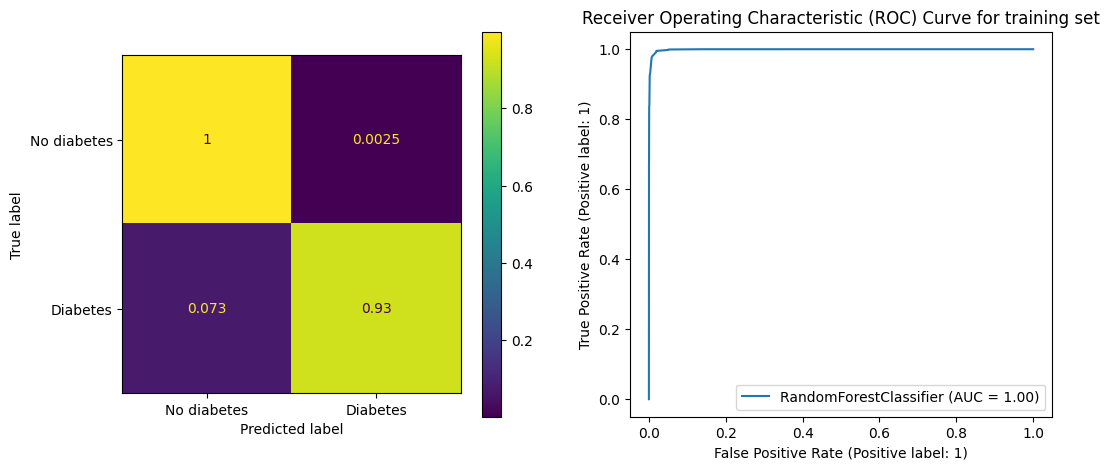

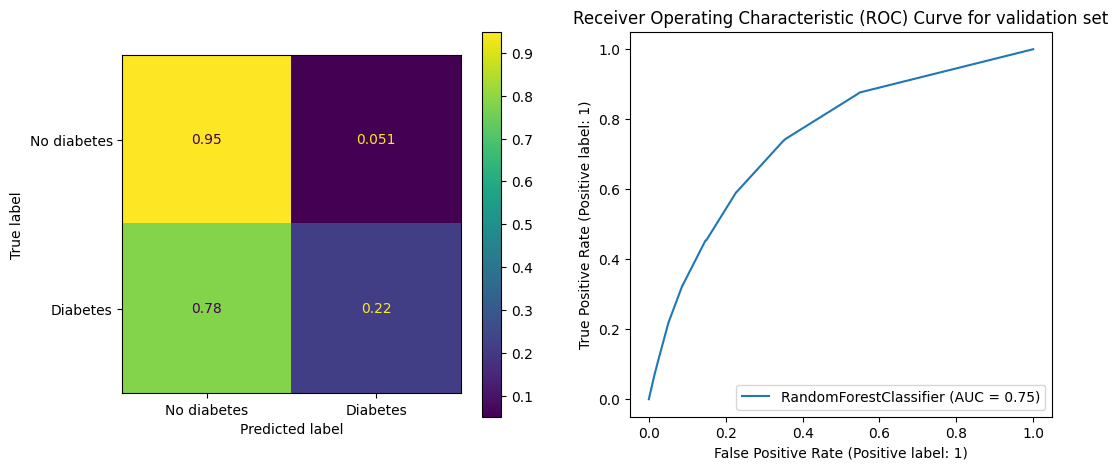

In [88]:
plot_cm_roc(model=best_rf, X=X_train,y_true=y_train, dataset_name='training')
plot_cm_roc(model=best_rf)